# Deep Learning with Python (Chollet)

## 6.2 Understanding recurrent neural networks

Densely connected networks and convnets have no memory and each input is processed independently. 

- Relation between inputs is not adequately capture here.

The input consists of a single data point that is given to the network at once. In the IMDB example an entire movie review was transformed into a single large vector and processed in one go. Such networks are called *feedforward networks*. 

But if the temporal or sequential order matters, which it does when reading a text or considering time series, this is not an adequate way to express the data inputs. 

- When reading (text analysis): Previous words and the respective sentence structure are kept in memory to get a representation of the meaning conveyed over the sequence of one sentence.  
- In time series: It is the main characteristic of the time series that data points are not happening at the same time but sequentially. 

> A **recurrent neural network (RNN)** processes sequences by iterating through the sequence elements and maintains a *state* containing information relative to what is has seen so far. 

RNN is a type of neural network that has an internal loop, the input is processed in an iterative way.

<img src="./images/fig_6_9.png" width="40%">

- State of RNN resets between processing two different, independent sequences. 
- What changes: Data point is not longer processed in a single step; the network internally loops over sequence elements. 

Clarify notions of *loop* and *state* by implementing the forward pass of a toy RNN in Numpy. 

- RNN takes as input a sequence of vectors, which will be encoded as a 2D tensor of size `(timesteps, input_features)`
- It loops over timesteps, and at each step, it coniders its current state at t and the input at t 
 - of shape `(input_features,)` and combines them to obtain the output at t. 
- Then, the state for the next step is set to be this previous output. 
- No previous output for first timestep (initial state is zero)

```python
# pseudocode
state_t = 0

for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t
```

- f is an activation function: transformation of the input and state into an output parametrized by two matrices, W and U, and a bias vector b. 

```python
# pseudocode
state_t = 0

for input_t in input_sequence: 
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```
--- 

In [1]:
# numpy implementation
import numpy as np 

timesteps = 100
input_features = 32 # dimensionality of input feature space
output_features = 64 # dimensionality of output feature space

# input data: random noise for the example
inputs = np.random.random((timesteps, input_features))
print("Shape of inputs: ", inputs.shape)

state_t = np.zeros((output_features,)) # an all-zero vector
print("Shape of state vector: ",state_t.shape)

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []

for input_t in inputs: 
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t # updates the state of the network for next timestep
    
print("Length of outputs: ", len(successive_outputs))

final_output_sequence = np.concatenate(successive_outputs, axis=0)
print(final_output_sequence.shape)

Shape of inputs:  (100, 32)
Shape of state vector:  (64,)
Length of outputs:  100
(6400,)


In summary, an RNN is a `for`loop that reuses quantities computed during the previous iteration of the loop, nothing more. 

RNNs are characterized by their step function (same as activation function?) Here, this is
```python
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
```

The final output is a 2D tensor of shape `(timesteps, output_features)`, where each timestep is the output of the loop at time t. Each timestep t in the output tensor contains infomration about timesteps 0 to t in the input sequence - about the entire past. Hence, in many cases, we don't need the full sequence of outputs and just the last output (`output_t` at the end of the loop) because it already contains information about the entire sequence. 

## A recurrent layer in Keras

Using `SimpleRNN` layer. Note that this layer processe batches of sequences, not a single sequence as in the example above. 

- Inputs of shape: `(batch_size, timesteps, input_features)

Links: 

- `keras.layers.SimpleRNN()`: Fully-connected RNN where the output is to be fed back to input [(link)](https://keras.io/layers/recurrent/).
- `keras.layers.Embedding()`: Turns positive integers (indexes) into dense vectors of fixed size, e.g. `[[4], [20]]` $\rightarrow$ `[[0.25, 0.1], [0.6, -0.2]]`
 - This layer can only be used as the first layer in a model. 
 
 
 

#### Example that uses `SimpleRNN` and returns only the output at the last timestep.

- returns only the last output for each input sequence, a 2D tensor of shape `(batch_size, output_features)`

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


#### Example that returns the full state sequence

- returns full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`
- see output shape of last layer

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Sometimes it's useful to stack several recurrent layers one after the other in order to incraese the representational power of a network. In such a setup, you have to get all of the intermediate layers to return full sequence of outputs. 

In [4]:
# Example
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32)) # only returns last output
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


#### Application to IMDB data
- keras.datasets: [Link](https://keras.io/datasets/)
```python
from keras.datasets import imbd
(x_train, y_train), (x_test, y_test ) = imdb.load_data(...)
```
- Returns:
 - x_train, x_test: list of sequences, which are lists of indexes (integers)
 - y_train, y_test: list of integer labels (1 or 0).  
- num_words: Top most frequent words to consider. 


- `sequence.pad_sequences()`: Pads sequences to the same length. 
 - This function transforms a list of `num_sampels` sequences (list of integers) into a 2D Numpy array of shape `(num_samples, num_timesteps)`. 
 - `num_timesteps`is either the `maxlen` argument provided, or the length of the longest sequence otherwise. 

- Returns: 
 - x: Numpy array with shape `(len(sequences), maxlen)`
 
- `evaluate()`method: Returns the loss value & metrics values for the model in test mode ([link](https://keras.io/models/model/)). 

In [5]:
### Preprocessing the data ###

# imports 
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 # num of words to consider as features 
maxlen = 500 # cuts off text after this many words
batch_size = 32

# loading data
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

# shape before
print("Shape of input_train", input_train.shape)
print("Shape of input_test", input_test.shape)

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

# shape after
print("Shape of input_train", input_train.shape)
print("Shape of input_test", input_test.shape)

Shape of input_train (25000,)
Shape of input_test (25000,)
Shape of input_train (25000, 500)
Shape of input_test (25000, 500)


In [6]:
### Training the model ###

# imports 
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation="sigmoid"))

# compile
model.compile(optimizer="rmsprop", 
              loss="binary_crossentropy", 
              metrics=["acc"])

# fit
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 61s 3ms/step - loss: 0.6449 - acc: 0.6103 - val_loss: 0.4840 - val_acc: 0.7794
Epoch 2/10
20000/20000 [==============================] - 65s 3ms/step - loss: 0.4097 - acc: 0.8235 - val_loss: 0.3841 - val_acc: 0.8398
Epoch 3/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.3034 - acc: 0.8779 - val_loss: 0.3989 - val_acc: 0.8270
Epoch 4/10
20000/20000 [==============================] - 74s 4ms/step - loss: 0.2059 - acc: 0.9221 - val_loss: 0.3712 - val_acc: 0.8590
Epoch 5/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.1436 - acc: 0.9475 - val_loss: 0.4543 - val_acc: 0.8066
Epoch 6/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0904 - acc: 0.9700 - val_loss: 0.4099 - val_acc: 0.8606
Epoch 7/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.0667 - acc: 0.9787 - val_loss: 0.4634 - val_acc:

In [7]:
### Plotting results ###
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# matplotlib 
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

This small recurrent network doesn't perofrm well compared to previous baselines. 

- Problem: Inputs consider only the first 500 words, rather than full sequences. 
 - `SimpleRNN` isn't good at processing long sequences, such as text.
 
## Understanding LSTM and GRU layers

Besides `SimpleRNN`, there are two other recurrent layer available in Keras: 

- `LSTM`
- `GRU`

In practice, these are the two that will be used. Due to what is known as *vanishing gradient problem* the simple layer does not actually work well on these kinds of problems. 

> Vanishing gradient problem is an effect where, as you keep adding layers (for example in feedforward networks) the network eventually becomes untrainable. 

The `LSTM` and `GRU`layers are designed to solve this problem. 

#### LSTM
The underlying Long Short-Term Memory (LSTM) algorithm was developed by Hochreiter and Schmidhuber in 1997 who were studying the vanishing gradient problem. In comparison to the `SimpleRNN` layer it adds a way to carry information across many timesteps. 

> The LSTM saves information for later, thus preventing older signals fromg gradually vanishing during processing. 

Schematically, the SimpleRNN can be expressed as 

<img src="../images/fig_6_13.png">

Now, an additional data flow that carries (hence c) information across timesteps is added. This carried information will be combined with the input connction and the recurrent connection so that the current output depends on the current *state* as well as the current information of the *carrier*. 

<img src="../images/fig_6_14.png">

This is done via a dense transformation (dot product with a weight matrix followed by a bias add and the application of an activation function), and it will affect the state being sent to the next timestep. Conceptually, the carry dataflow is a way to modulate the next output and the next state. 

Compute the next value of the carry dataflow

```python
# pseudocode details of LSTM architecture
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

# carry state obtained by combining i_t, f_t, k_t
c_t+1 = i_t*k_t + c_t*f_t
```

This can be illustrated as

<img src="../images/fig_6_15.png">

#### Example: Using the LSTM layer in Keras

- `keras.layers.LSTM()`: Long Short-Term Memory layer - Hochreiter 1997 [(link)](https://keras.io/layers/recurrent/)


In [8]:
# imports
from keras.layers import LSTM

model=Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["acc"])

history = model.fit(input_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 118s 6ms/step - loss: 0.5081 - acc: 0.7624 - val_loss: 0.3332 - val_acc: 0.8596
Epoch 2/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.2887 - acc: 0.8867 - val_loss: 0.3213 - val_acc: 0.8590
Epoch 3/10
20000/20000 [==============================] - 141s 7ms/step - loss: 0.2309 - acc: 0.9125 - val_loss: 0.3043 - val_acc: 0.8806
Epoch 4/10
20000/20000 [==============================] - 133s 7ms/step - loss: 0.1951 - acc: 0.9277 - val_loss: 0.4022 - val_acc: 0.8696
Epoch 5/10
20000/20000 [==============================] - 138s 7ms/step - loss: 0.1738 - acc: 0.9361 - val_loss: 0.3280 - val_acc: 0.8858
Epoch 6/10
20000/20000 [==============================] - 135s 7ms/step - loss: 0.1585 - acc: 0.9418 - val_loss: 0.4693 - val_acc: 0.8266
Epoch 7/10
20000/20000 [==============================] - 128s 6ms/step - loss: 0.1393 - acc: 0.9502 - val_loss: 0.4563 - v

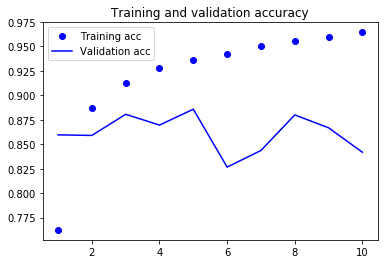

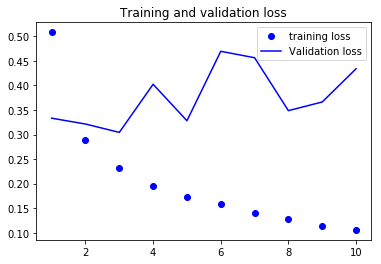

In [9]:
### Plotting results ###
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# matplotlib 
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### Results

- Better than `SimpleRNN` but definitely not groundbreaking
 - In particular, considering that this approach is computationally more intensive
- Additional hyperparameter tuning may be beneficial (i.e. embeddings dimensionality or the LSTM output dimensionality)
- Lack of regularization

But a more basic problem is that analyzing the **global, long-term structure** of the reviews (what LSTM is good at) isn't helpful for a sentiment-analysis problem.

> LSTM are good at analysiing global, long-term structures.